# Distributions of token distances
The aim of this notebook is to investigate the evolution of the distances between input token embeddings throughout the different modules and layers of the GPT2 model. The focus lies on the analysis of the distribution of distances to the last token in the input sequence.

To Do:
- Should the distance evolution plots be kept or discarded so that only the KDE plots are shown instead?
- Add distance calculation / heatmaps

##### Library imports:

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import transformers
import torch
import sklearn.manifold
import sklearn.metrics
import scipy
import numpy as np
import matplotlib.pyplot as plt
import warnings
import DistFuncs as DF # file containing various helper functions

## Calculating token distances for each module

In [2]:
# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# define input prompt
prompt = "A pancake (or hotcake, griddlecake, or flapjack) is a flat cake, often thin and round, prepared from a starch-based batter that may contain eggs, milk and butter, and then cooked on a hot surface such as"

# extract module outputs and names
outputs, modules =  DF.get_layer_outputs(model, tokenizer, prompt)

# get indices of layers where outputs have the right shape
ref_shape = outputs[0].shape
idx = np.array([i for i, o in enumerate(outputs) if o.shape == ref_shape])

# filter to get the outputs & module names at idx
filtered_outputs = np.array([outputs[i] for i in idx])
module_names = np.array([str(modules[i]).split('(', 1)[0].strip() for i in idx])

# calculate pairwise token distances
#distances = dist_matr(filtered_outputs, type="euclid") # euclidean distance
distances_cos = DF.dist_matr(filtered_outputs, type="cosine") # cosine distance

# create plot labels & titles from tokens & layer names
token_labels = [tokenizer.decode(t) for t in tokenizer.encode(prompt, return_tensors="pt")[0]]
mod_idx = [f"{idx[i]} {module_names[i]}" for i in range(len(idx))]

# create heatmap plot of pairwise token distances for each layer
# here: using a shared linear scale for all plots
# can also be set do individual scales or shared/individual log scale
DF.plot_dist_heatmap(distances_cos, token_labels, mod_idx, scaling='SharedLin', filename="distances_cos")

D:\anaconda3\envs\pytorch_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Creating plot 1/113. Module 0 Embedding
Creating plot 2/113. Module 1 Embedding
Creating plot 3/113. Module 2 Dropout
Creating plot 4/113. Module 3 LayerNorm
Creating plot 5/113. Module 6 Conv1D
Creating plot 6/113. Module 7 Dropout
Creating plot 7/113. Module 8 GPT2Attention
Creating plot 8/113. Module 9 LayerNorm
Creating plot 9/113. Module 12 Conv1D
Creating plot 10/113. Module 13 Dropout
Creating plot 11/113. Module 14 GPT2MLP
Creating plot 12/113. Module 15 GPT2Block
Creating plot 13/113. Module 16 LayerNorm
Creating plot 14/113. Module 19 Conv1D
Creating plot 15/113. Module 20 Dropout
Creating plot 16/113. Module 21 GPT2Attention
Creating plot 17/113. Module 22 LayerNorm
Creating plot 18/113. Module 25 Conv1D
Creating plot 19/113. Module 26 Dropout
Creating plot 20/113. Module 27 GPT2MLP
Creating plot 21/113. Module 28 GPT2Block
Creating plot 22/113. Module 29 LayerNorm
Creating plot 23/113. Module 32 Conv1D
Creating plot 24/113. Module 33 Dropout
Creating plot 25/113. Module 34 

## Evolution of distances to last token throughout the layer modules
A test prompt of ~750 tokens is used to observe how the distances from each token to the last one in the sequence evolve throughout the different modules that make up the module layers. For each module (except those whose output has a different dimension), the outputs are extracted, and the cosine distances between the tokens are calculated. The evolution of the distances to the last token throughout the modules are then visualised.

### Initialise model, extract outputs & calculate distances:

In [3]:
# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# define input prompt
prompt = f"A pancake (or hotcake, griddlecake, or flapjack) is a flat cake, often thin and round, prepared from a starch-based batter that may contain eggs, milk and butter, and then cooked on a hot surface such as a griddle or frying pan. It is a type of batter bread. Archaeological evidence suggests that pancakes were probably eaten in prehistoric societies. The pancake's shape and structure varies worldwide. In England, pancakes are often unleavened and resemble a crêpe. In Scotland and North America, a leavening agent is used (typically baking powder) creating a thick fluffy pancake. A crêpe is a thin pancake of Breton origin cooked on one or both sides in a special pan or crepe maker to achieve a lacelike network of fine bubbles. A well-known variation originating from southeast Europe is palatschinke, a thin moist pancake fried on both sides and filled with jam, cream cheese, chocolate, or ground walnuts, but many other fillings—sweet or savoury—can also be used. Commercially prepared pancake mixes are available in some countries. Like waffles, commercially prepared frozen pancakes are available from companies like Eggo. When buttermilk is used in place of or in addition to milk, the pancake develops a tart flavor and becomes known as a buttermilk pancake, which is common in Scotland, Ireland and the US. Buckwheat flour can be used in a pancake batter, making for a type of buckwheat pancake, a category that includes blini, kaletez, ploye, and memil-buchimgae. When potato is used as a major portion of the batter, the result is a potato pancake. Pancakes may be served at any time of the day or year with a variety of toppings or fillings, but they have developed associations with particular times and toppings in different regions. In North America, they are typically considered a breakfast food and serve a similar function to waffles. In Britain and the Commonwealth, they are associated with Shrove Tuesday, commonly known as \"Pancake Day\", when, historically, perishable ingredients had to be used up before the fasting period of Lent. Pancakes are traditionally eaten on Shrove Tuesday, which is known as \"Pancake Day\" in Canada, the United Kingdom, Ireland, New Zealand, and Australia, and \"Pancake Tuesday\" in Ireland and Scotland. (Shrove Tuesday is better known in the United States, France, and other countries as Mardi Gras or Fat Tuesday.) Historically, pancakes were made on Shrove Tuesday so that the last of the fat or lard was used up before Lent. No meat products should be eaten during Lent. Charity and school events are organized on Pancake Day: in a \"pancake race\" each participant carries a pancake in a frying pan. All runners must toss their pancakes as they run and catch them in the frying pan. This event is said to have originated in Olney, England in 1445 when a housewife was still busy frying pancakes to eat before the Lenten fast when she heard the bells of St Peter and St Paul's Church calling her to the Shriving Service. Eager to get to church, she ran out of her house still holding the frying pan complete with pancake, tossing it to prevent it from burning, and still wearing her apron and headscarf Every Shrove Tuesday since 1950, the towns of Olney and Liberal, Kansas have competed in the International Pancake Race. Only local women may compete; they race, and their times are compared to determine the international winner. In Olney the main women's race is augmented by races for local schoolchildren and for men."

# extract module outputs and names
outputs, mods =  DF.get_layer_outputs(model, tokenizer, prompt)

# filter outputs & get cosine distances to last token:
idx, module_names, dist_from_token = DF.get_last_token_distance(outputs, mods)

D:\anaconda3\envs\pytorch_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Plotting the distance evolution:

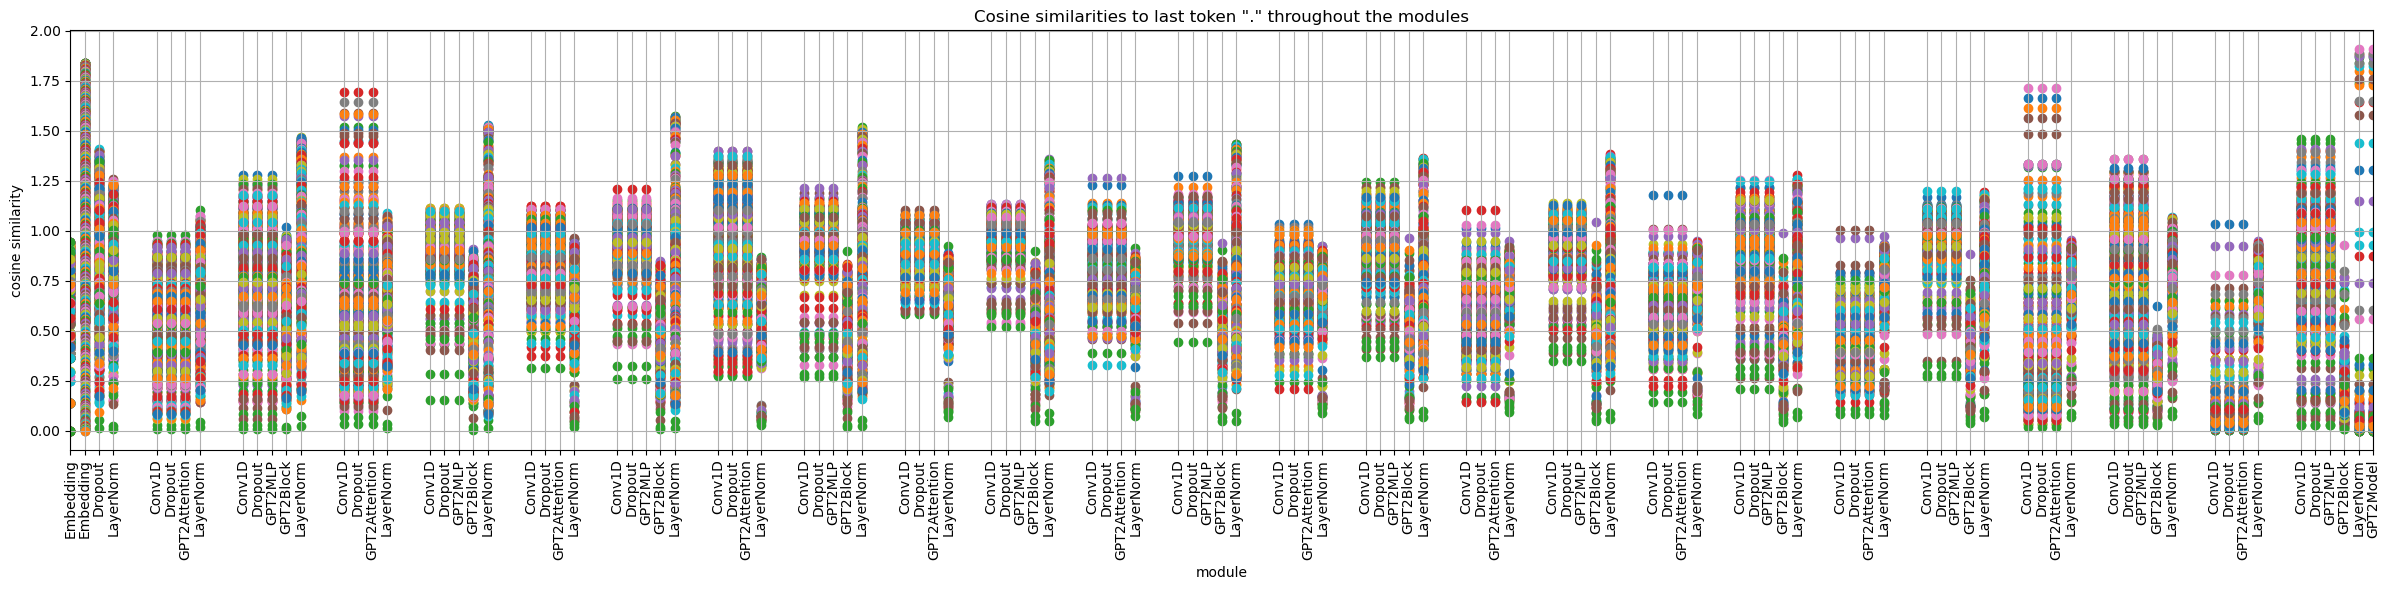

In [4]:
token_labels = [tokenizer.decode(t) for t in tokenizer.encode(prompt, return_tensors="pt")[0]]

fig, ax = plt.subplots(figsize=(24, 6))

#for i in token_list:
for i, lab in enumerate(token_labels[:-1]):
    ax.scatter(idx, dist_from_token.T[i], label=lab.strip(), lw=1, marker="o")
    #ax.plot(idx, dist_from_token.T[i], label=lab.strip(), lw=0.5, marker="o", markersize=4)

ax.set_title(f"Cosine similarities to last token \"{token_labels[-1].strip()}\" throughout the modules")
ax.set_xlabel("module")
ax.set_ylabel("cosine similarity")
ax.set_xticks(idx, module_names, rotation=90)
ax.set_xlim(min(idx), max(idx))
# ax.set_yscale('log')
#ax.legend(loc="upper left")
ax.grid()
fig.tight_layout()
plt.show()

### Distance evolution throughout the decoder blocks:
Furthermore, the cosine distances of the tokens after each decoder block in the GPT2 module is plotted. Each decoder block (`GPT2Block`) is composed of different modules as follows:

```python
GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
(1, 58, 768)
```


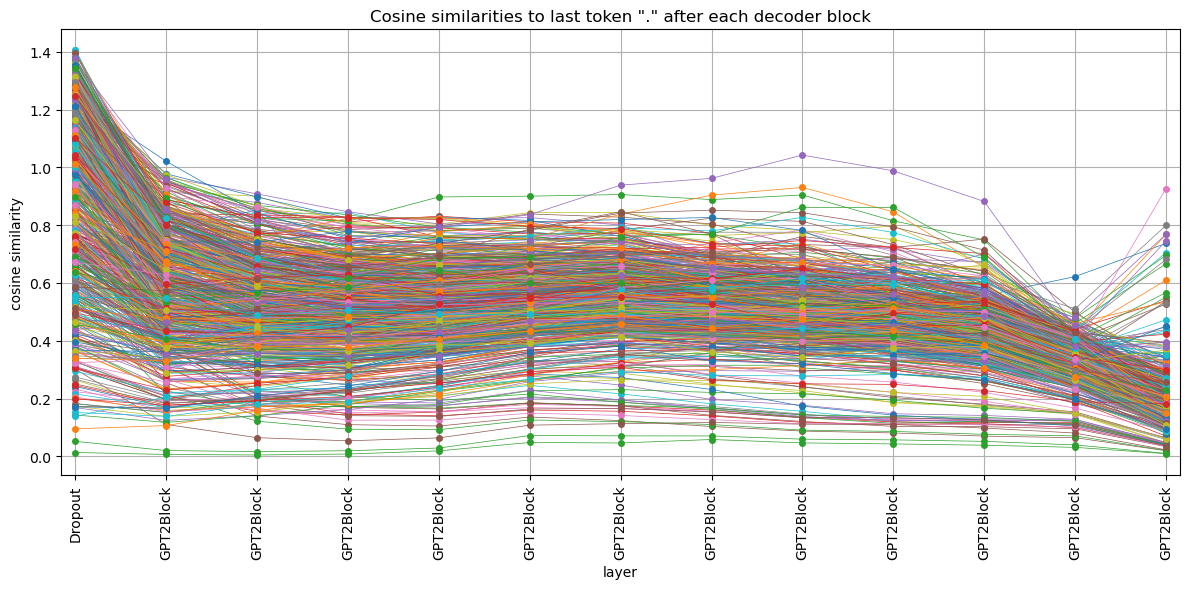

In [5]:
# filter for only the GPT2Block-outputs
gpt2block_mask = module_names == "GPT2Block"
# add position of embedding & first dropout output after embedding
gpt2block_mask[2] = True

token_labels = [tokenizer.decode(t) for t in tokenizer.encode(prompt, return_tensors="pt")[0]]

fig, ax = plt.subplots(figsize=(12, 6))

# for all except first token:
for i, lab in enumerate(token_labels[:-1]):
    ax.plot(idx[gpt2block_mask], dist_from_token.T[i][gpt2block_mask], label=lab.strip(), lw=0.5, marker="o", markersize=4)
    #ax.scatter(idx[gpt2block_mask], dist_from_token[i][gpt2block_mask], label=labels[i].strip(), lw=1, marker="o")


ax.set_title(f"Cosine similarities to last token \"{token_labels[-1].strip()}\" after each decoder block")
ax.set_xlabel("layer")
ax.set_ylabel("cosine similarity")
ax.set_xticks(idx[gpt2block_mask], module_names[gpt2block_mask], rotation=90)
ax.set_xlim(min(idx), max(idx))
# ax.set_yscale('log')
#ax.legend(loc="upper left")
ax.grid()
fig.tight_layout()
plt.show()

## KDE of token distance distribution
To better understand the distribution of the token distances, a KDE of the distribution of distances to the last token is analysed for each module. This analysis is conducted for 4 different input prompts of ~800 tokens, to allow for comparison.

In [6]:
# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Read prompts
prompt_files = {
    "Dracula": 'prompts/prompt_dracula.txt', # 853 tokens
    "Transformers": 'prompts/prompt_transformers.txt', # 817 tokens
    "Pancakes": 'prompts/prompt_pancake.txt', # 793 tokens
    "Moby Dick": 'prompts/prompt_moby_dick.txt' # 811 tokens
}
prompts = {label: DF.read_prompt(file_path) for label, file_path in prompt_files.items()}

# get outputs
outputs = {label: DF.get_layer_outputs(model, tokenizer, prompt)[0] for label, prompt in prompts.items()}

# get correctly ordered module names
mods = DF.get_module_names(model, tokenizer)

# Calculate distances to respective last token
# Dict contains Layer idx, module names and distances for each prompt
distances = {label: DF.get_last_token_distance(output, mods) for label, output in outputs.items()} 

D:\anaconda3\envs\pytorch_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


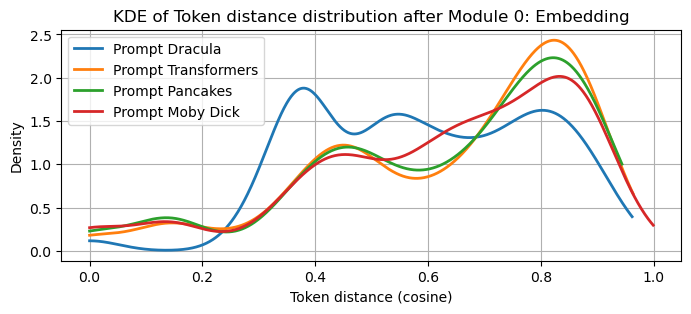

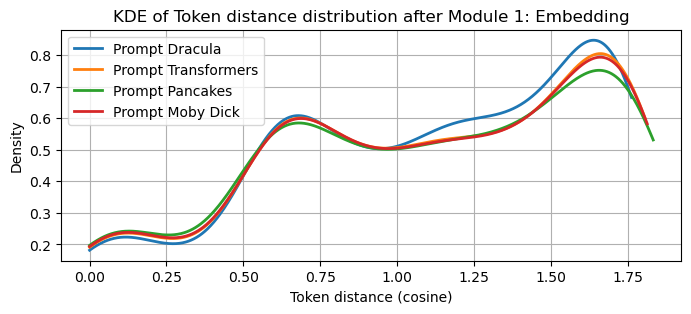

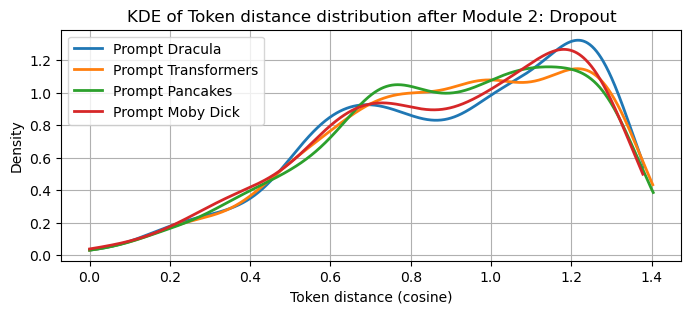

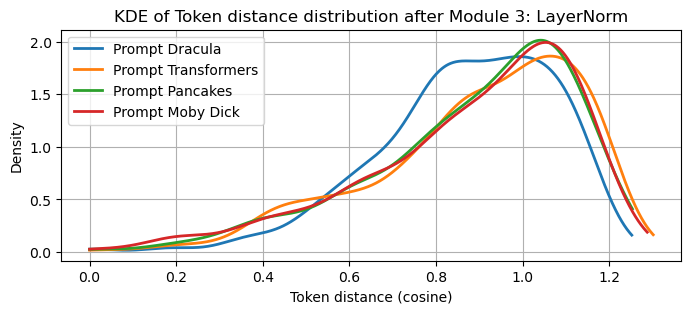

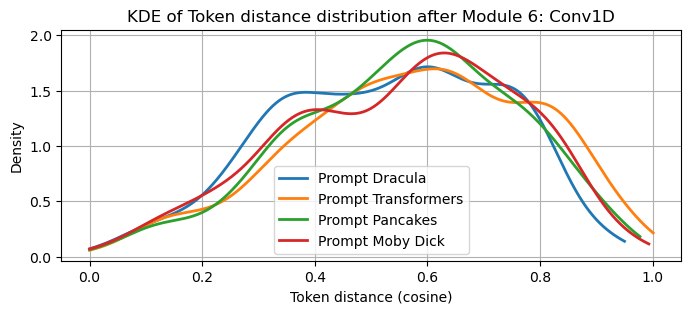

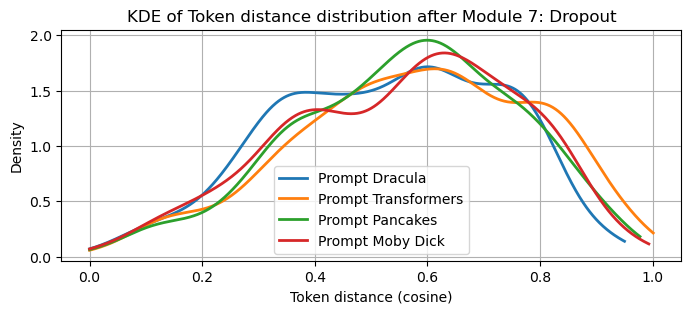

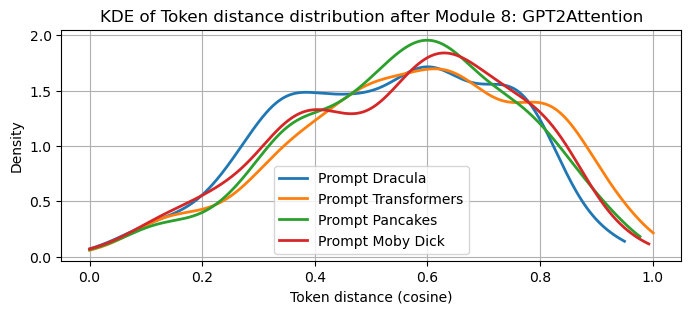

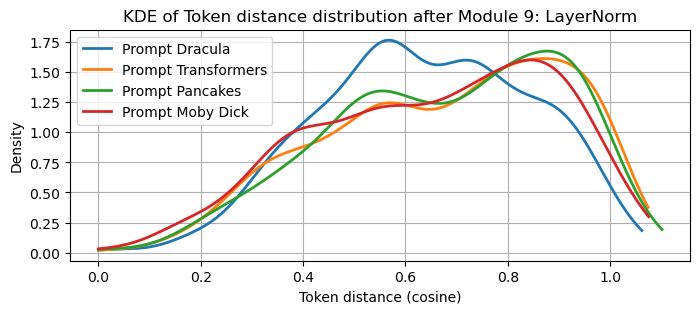

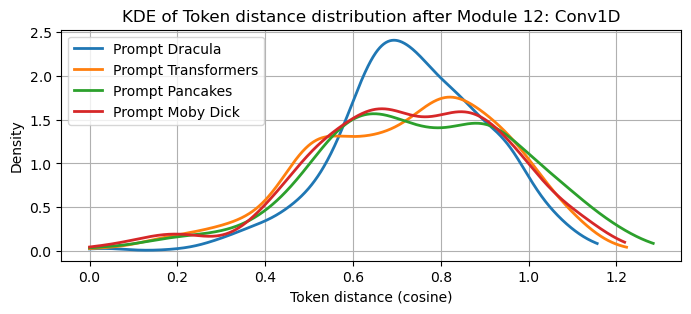

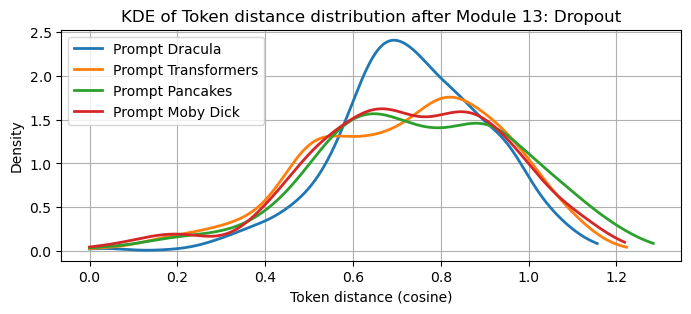

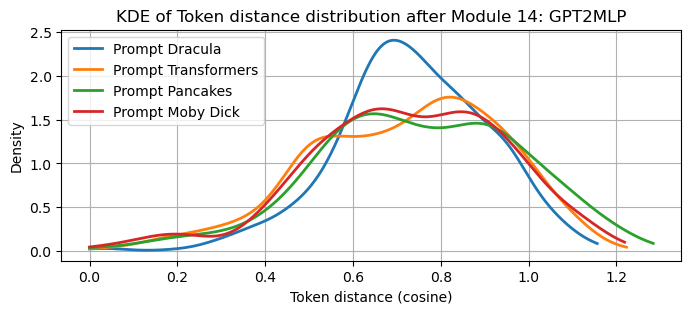

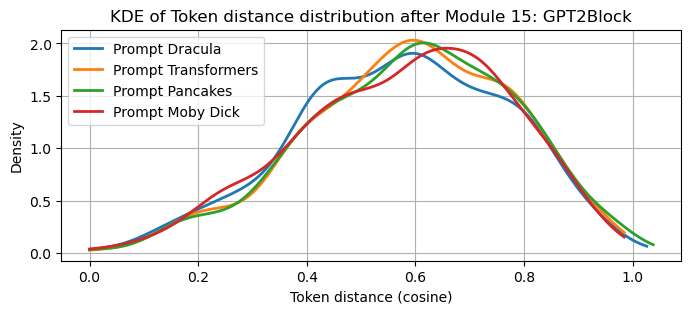

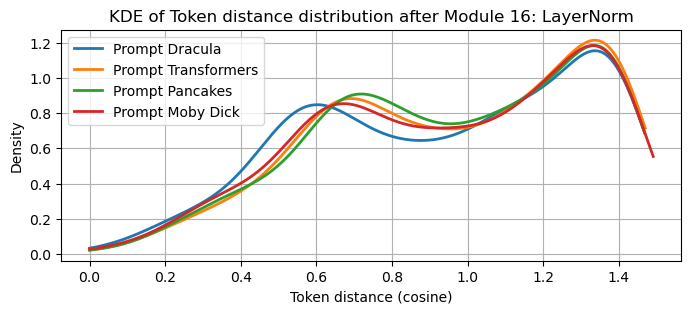

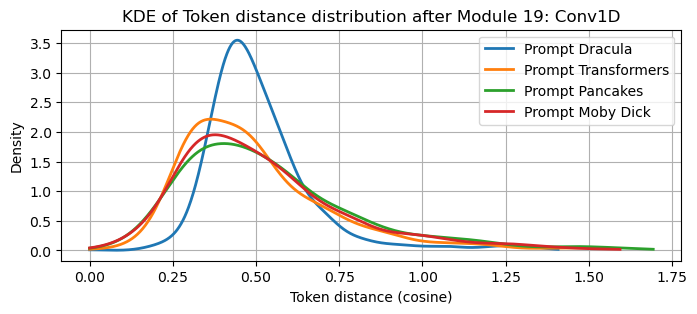

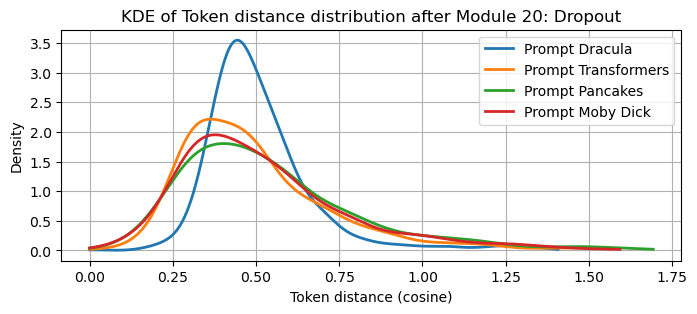

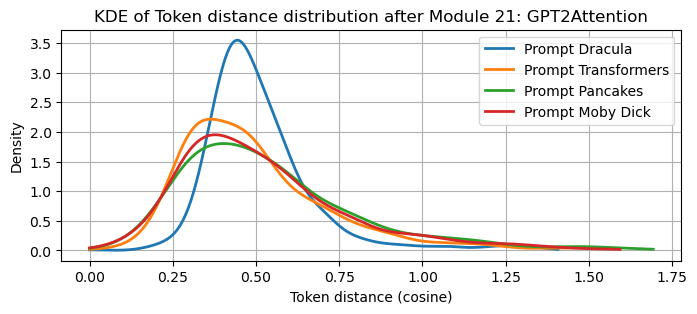

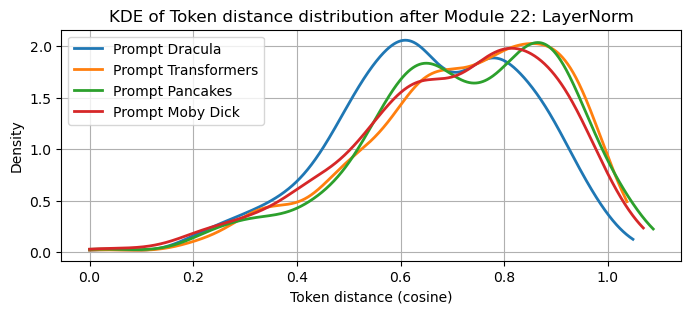

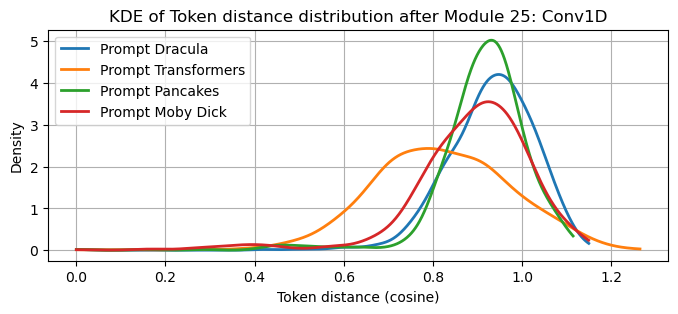

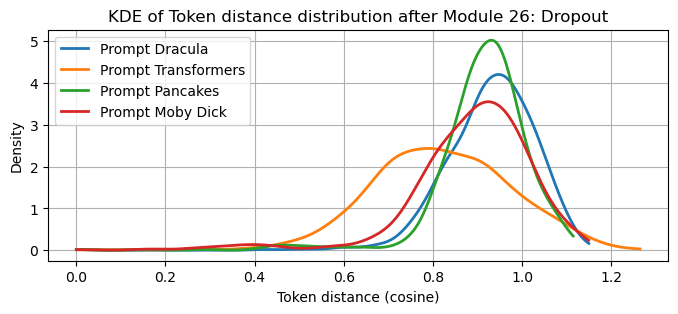

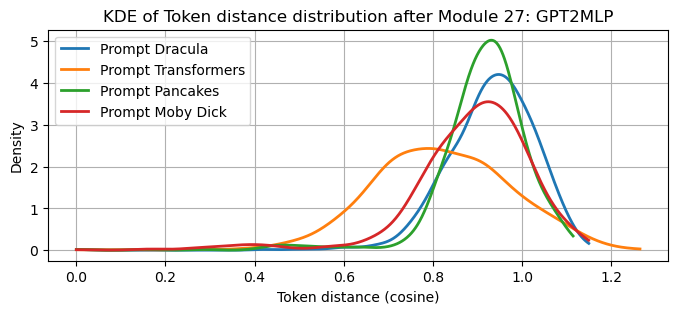

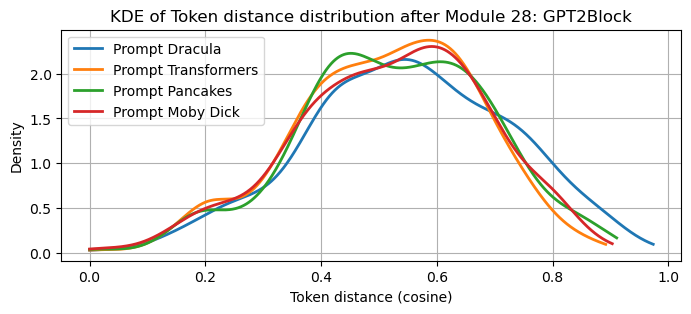

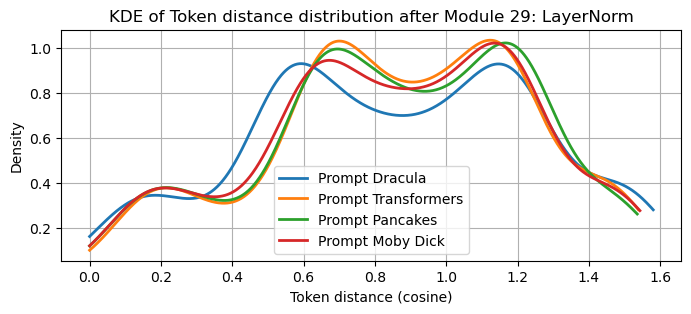

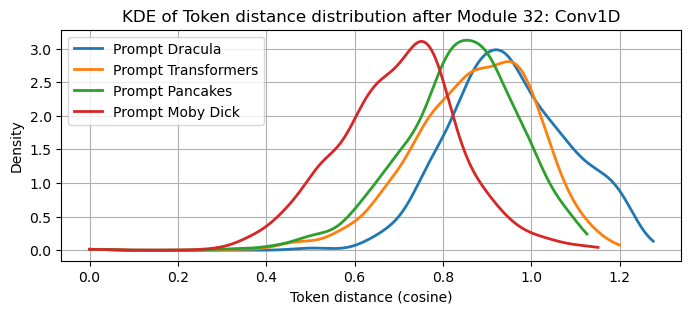

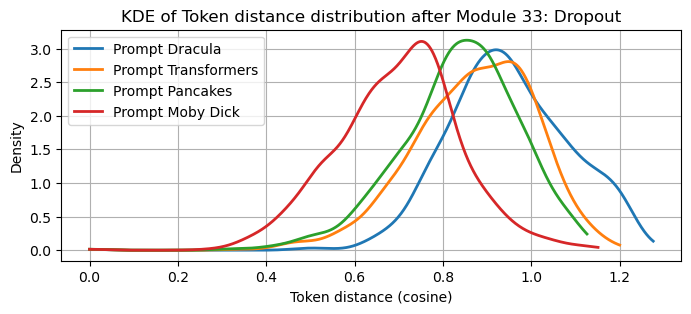

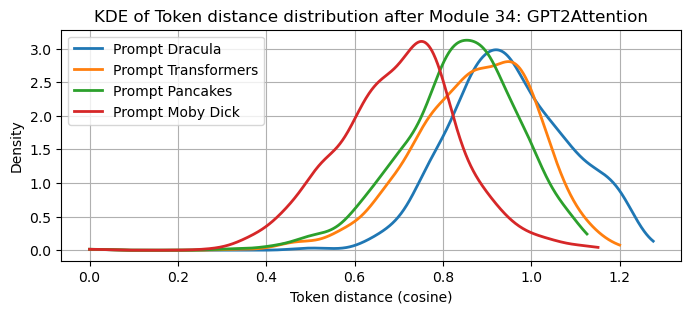

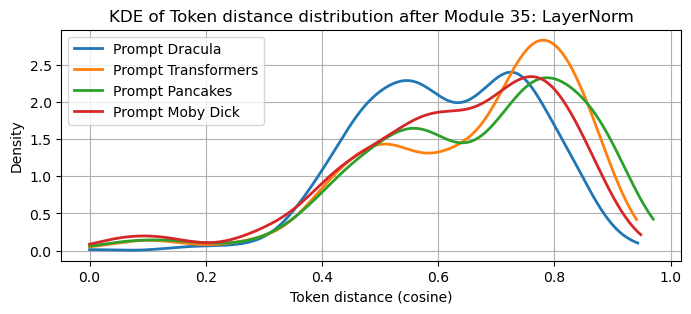

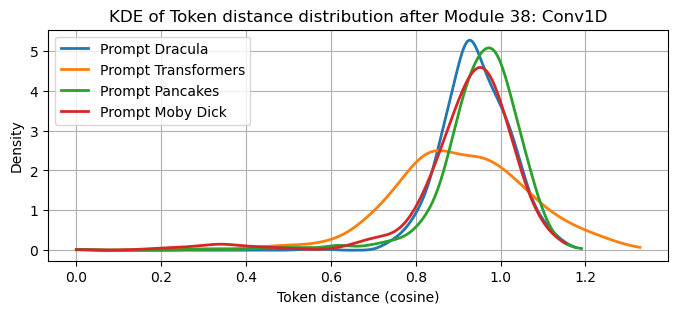

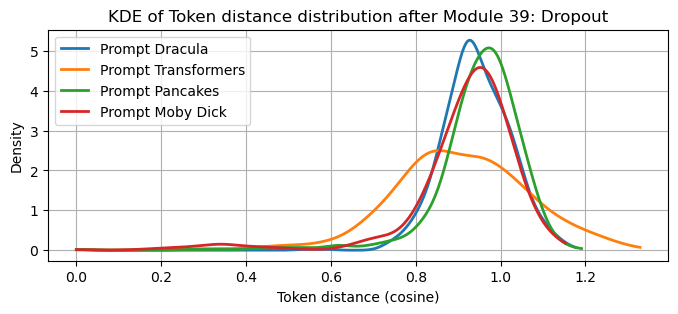

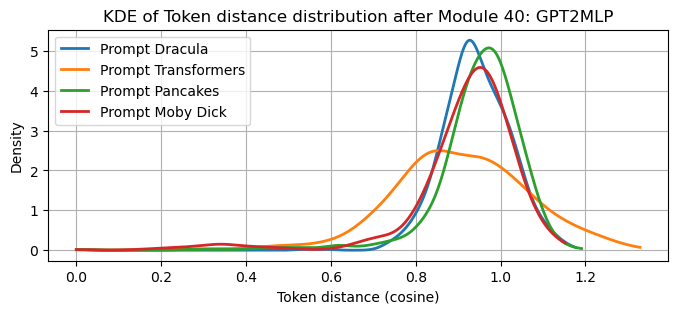

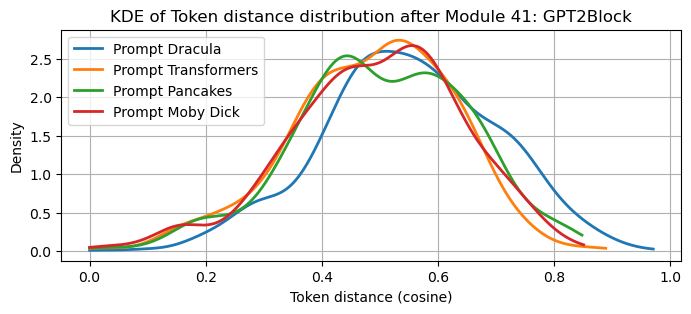

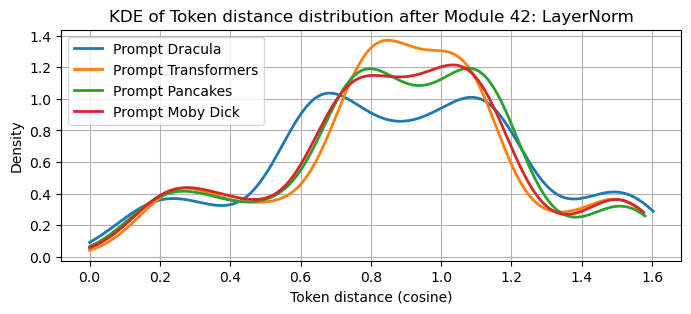

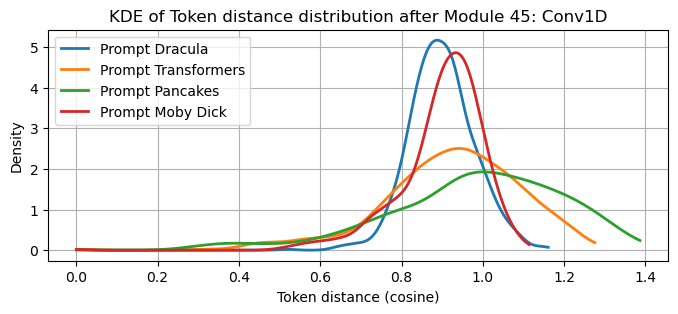

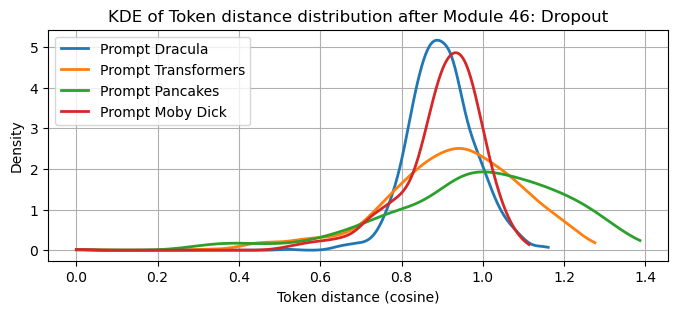

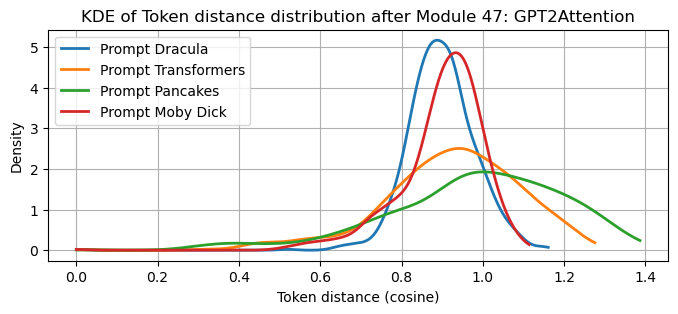

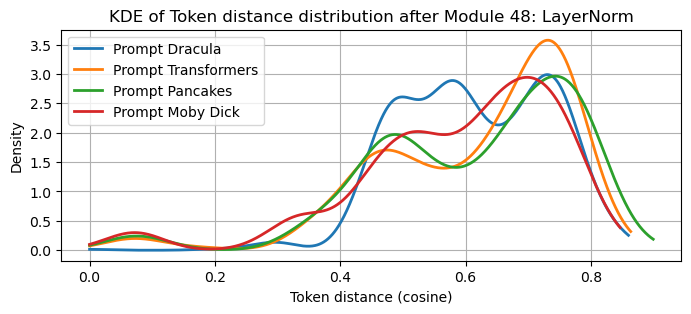

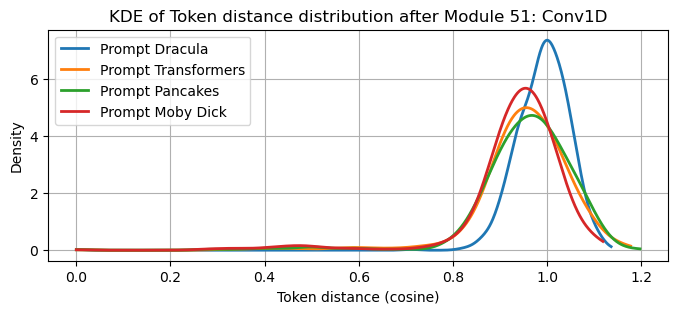

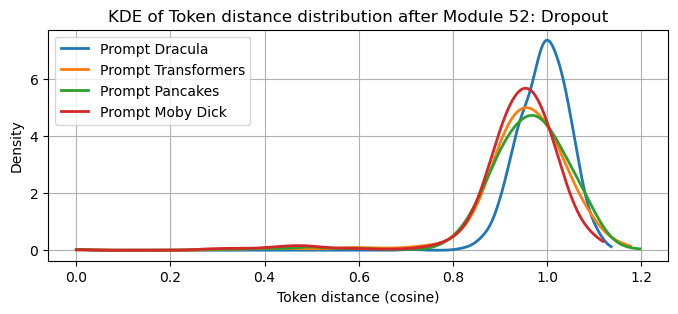

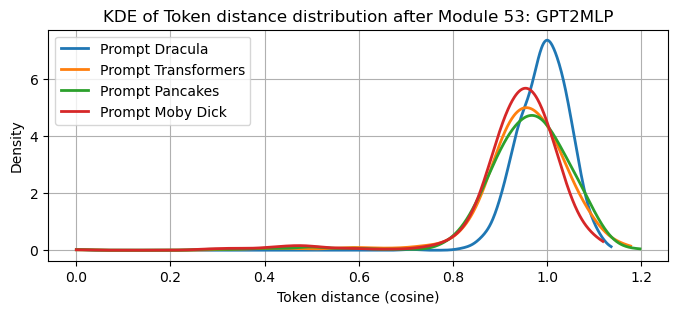

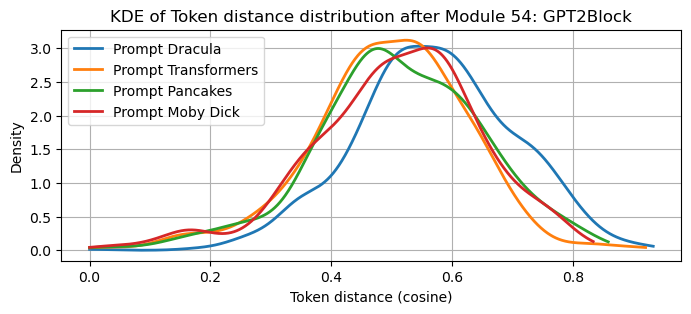

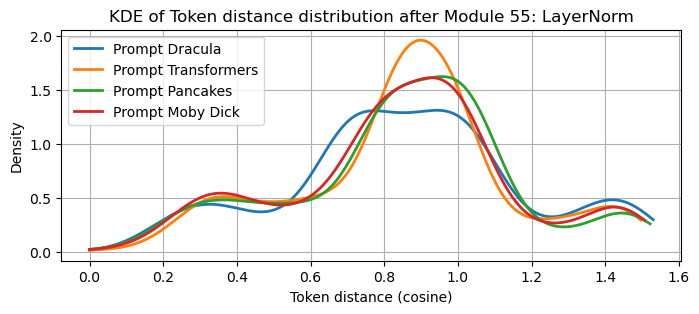

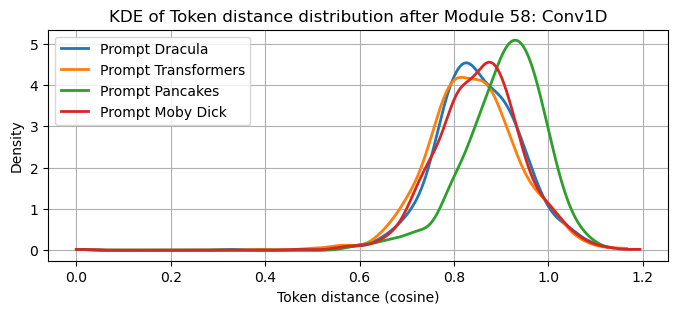

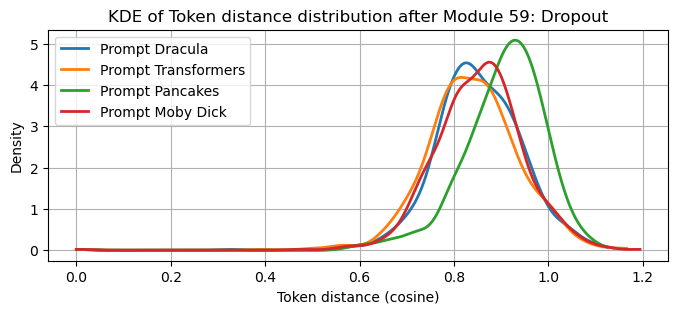

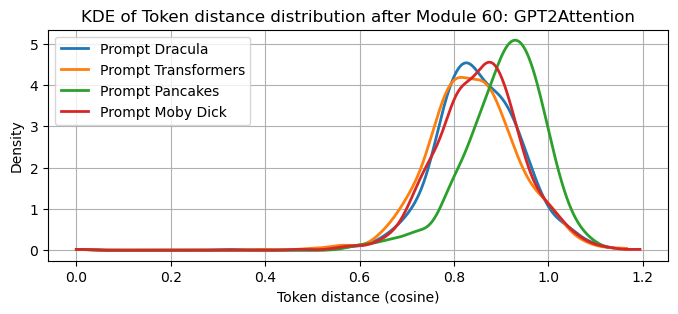

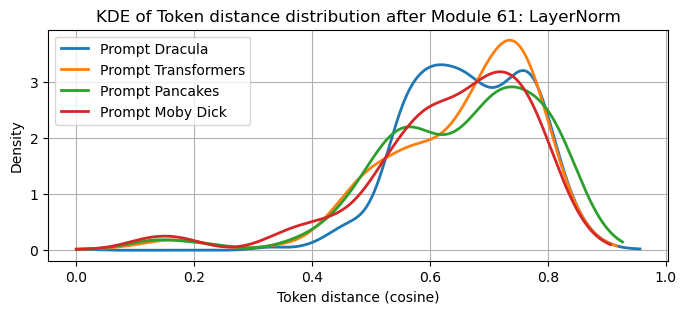

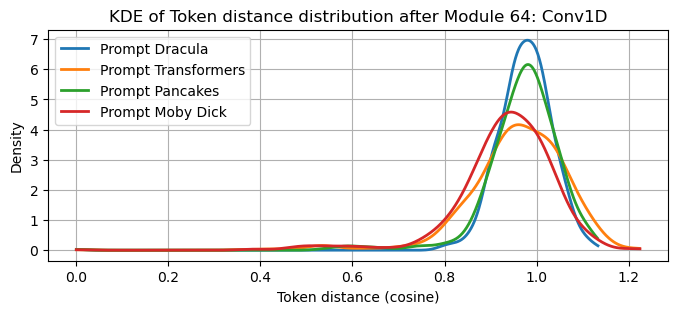

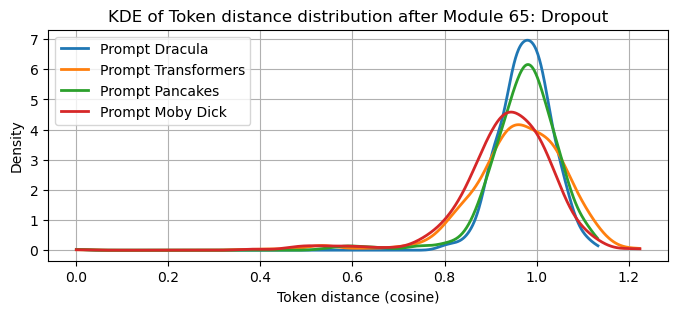

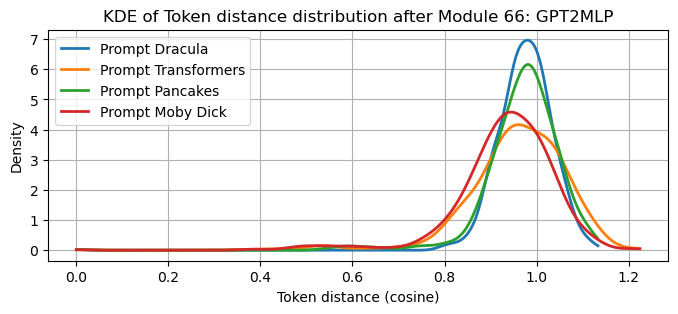

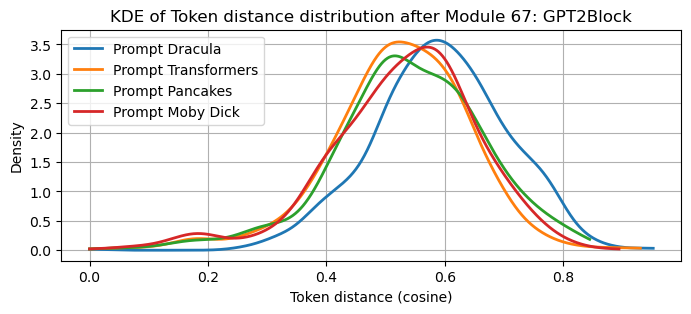

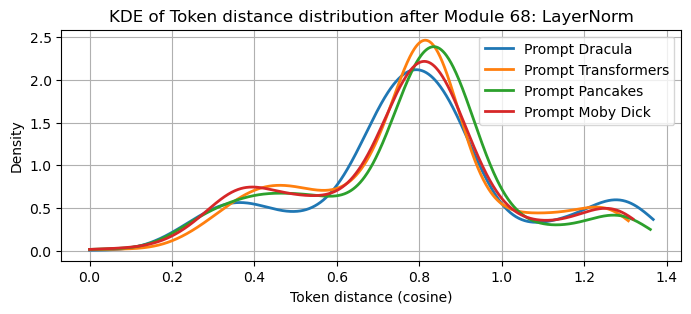

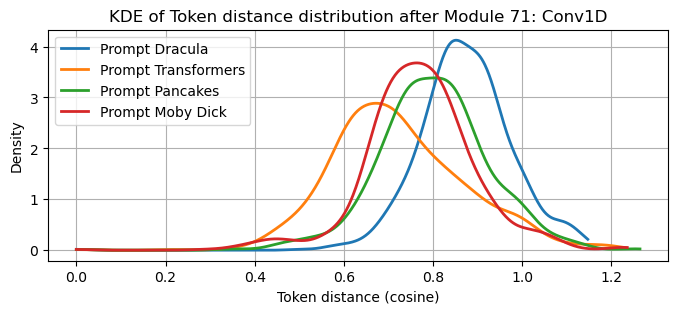

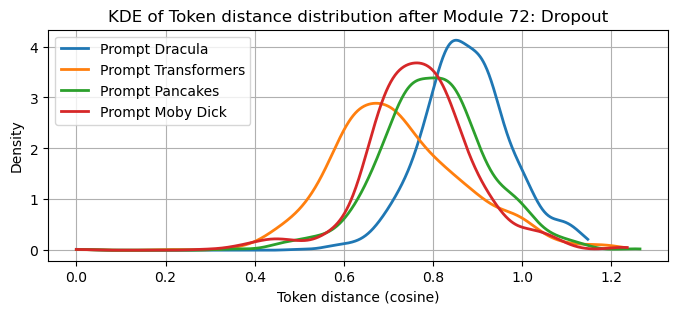

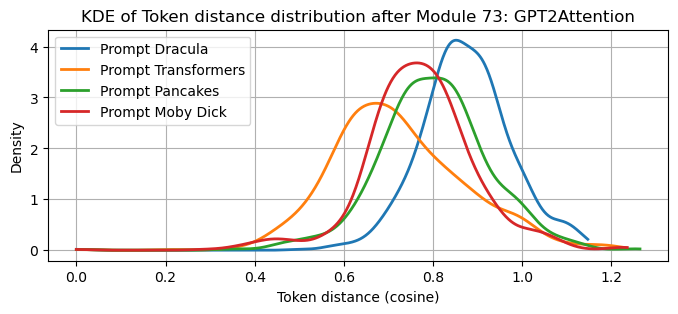

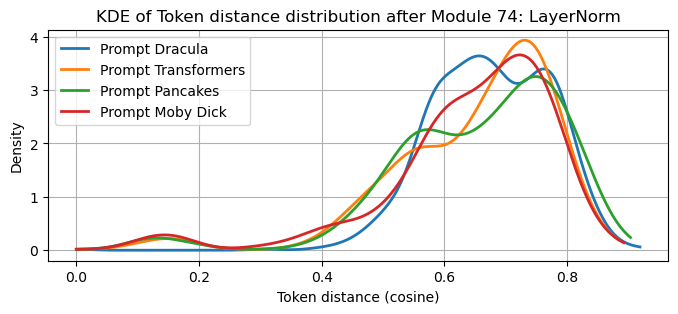

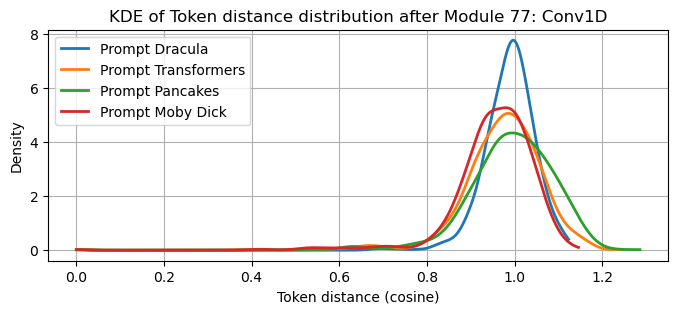

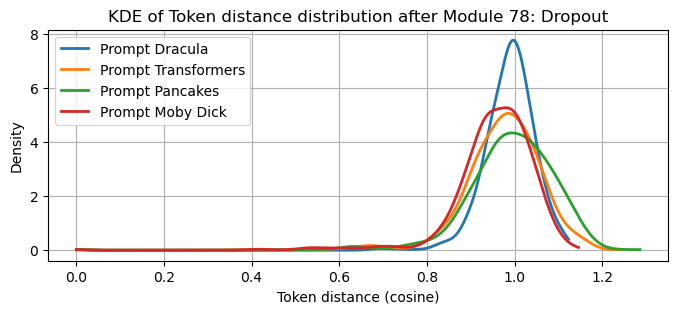

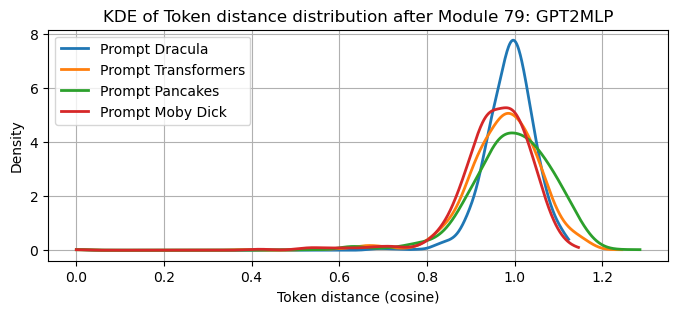

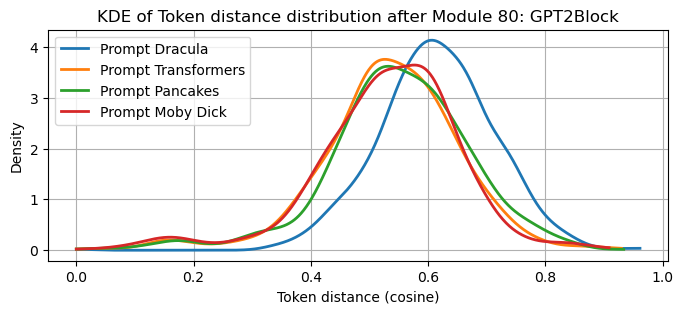

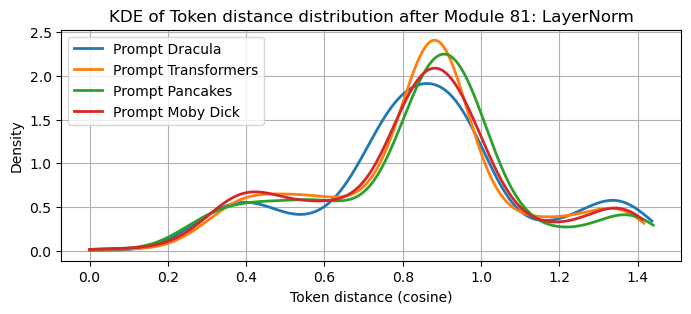

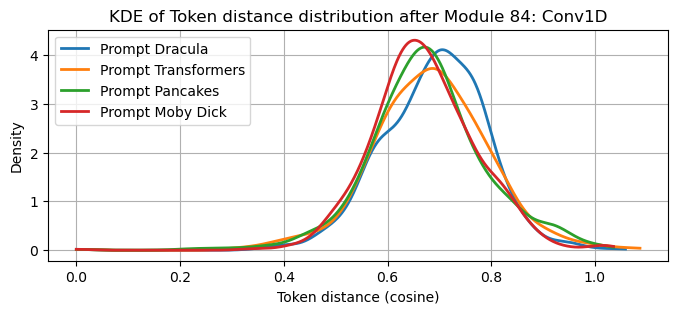

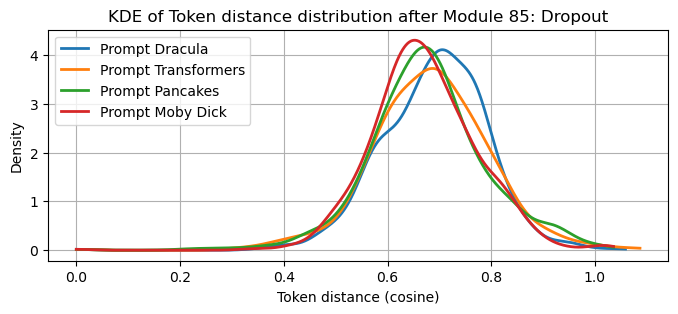

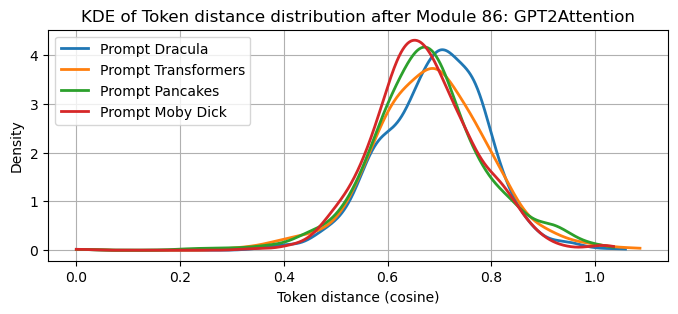

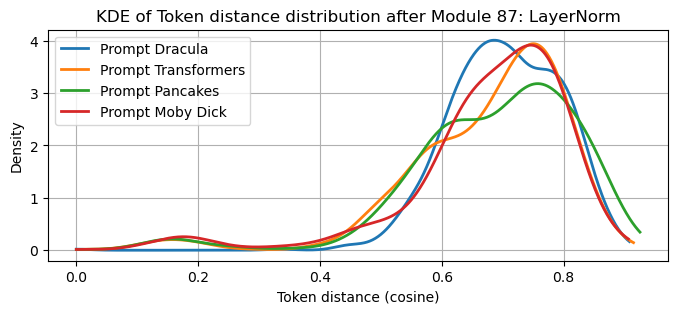

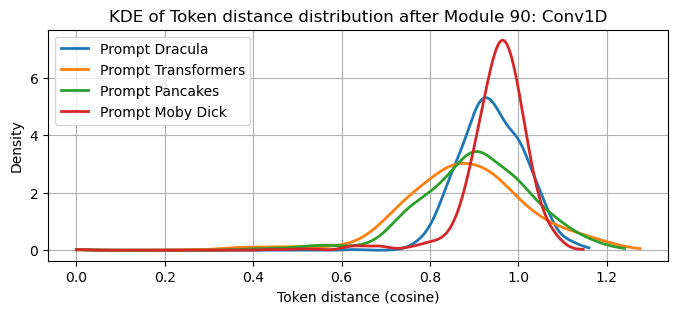

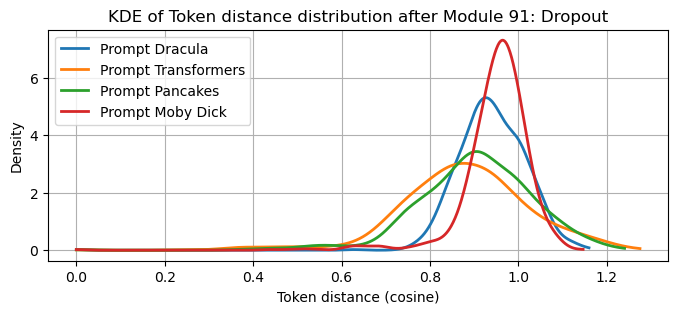

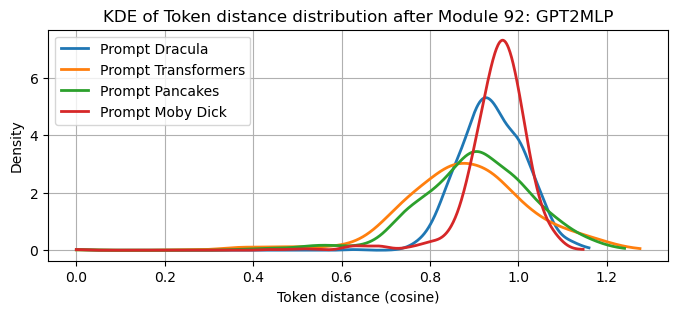

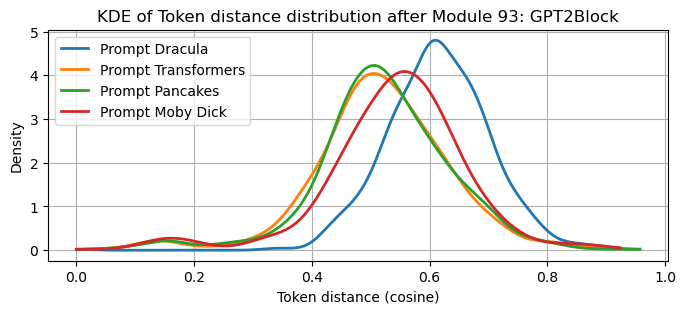

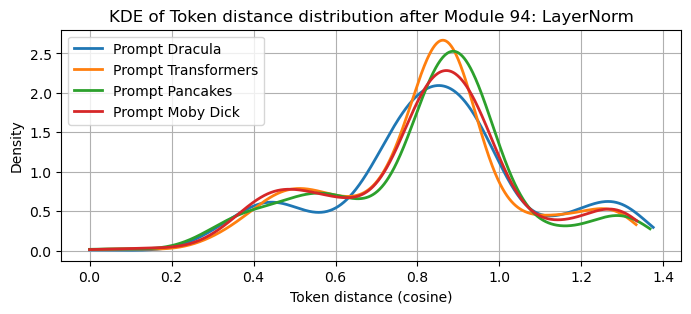

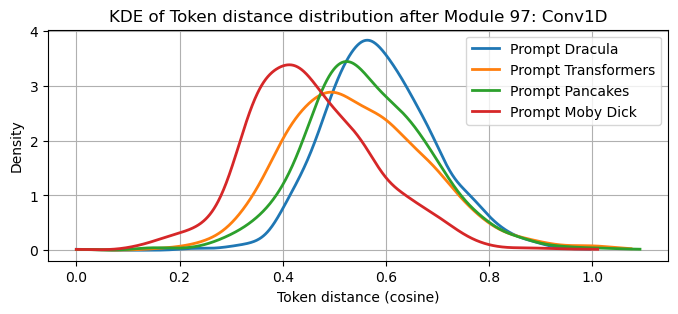

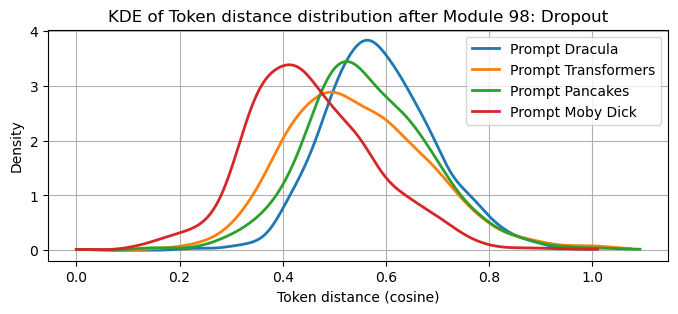

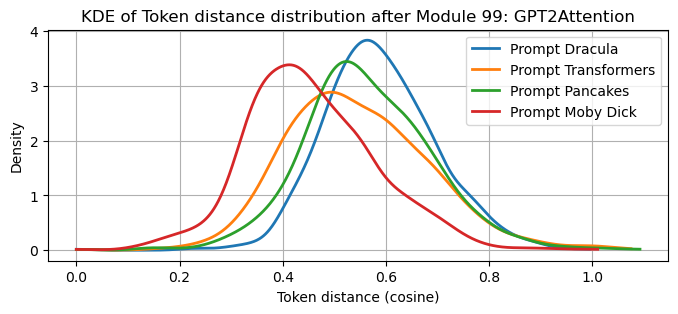

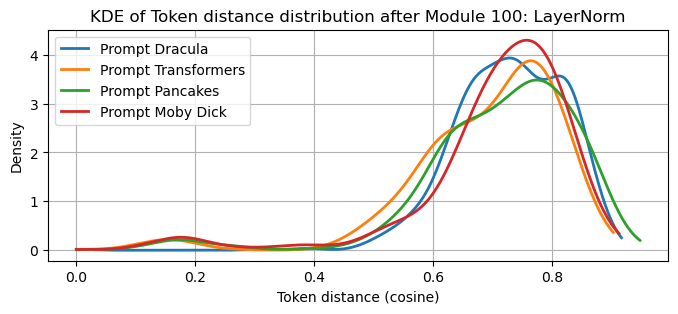

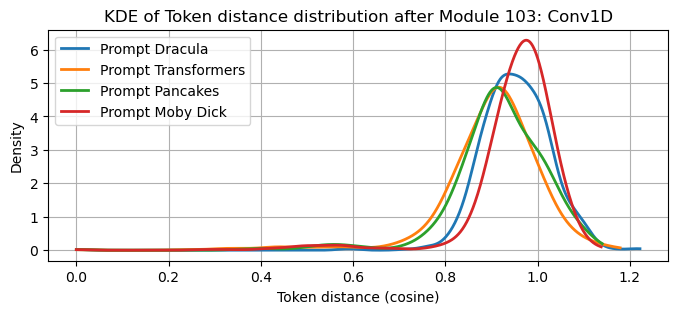

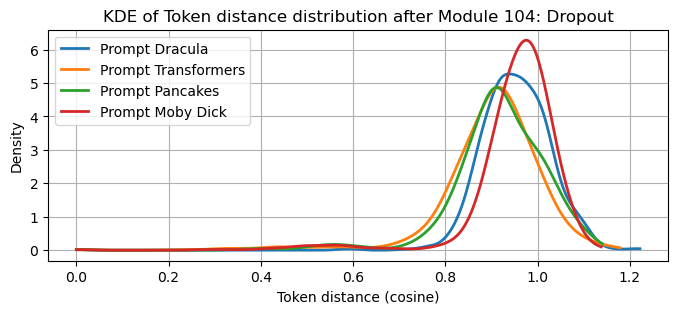

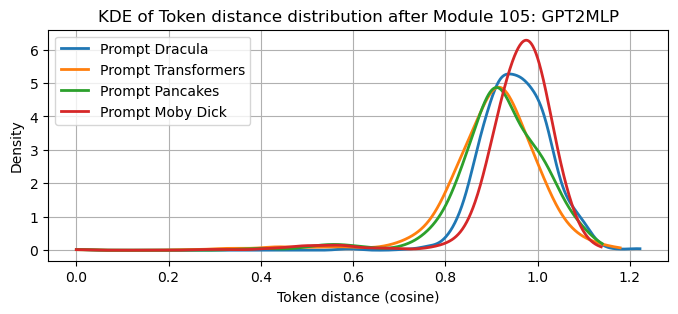

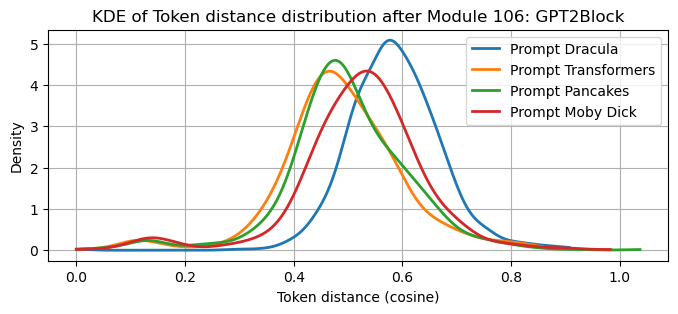

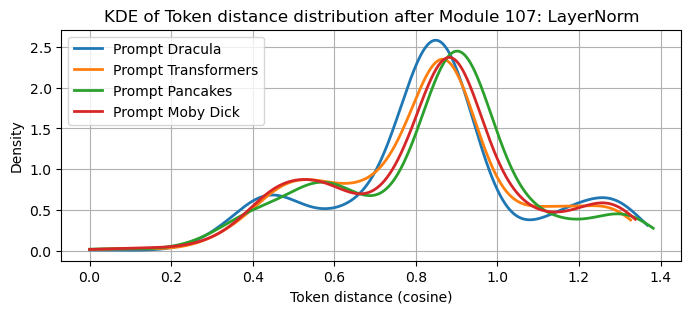

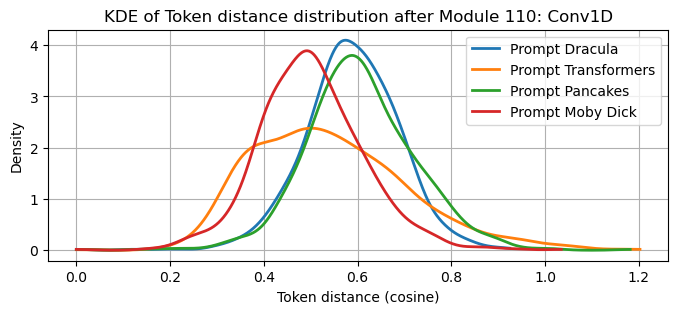

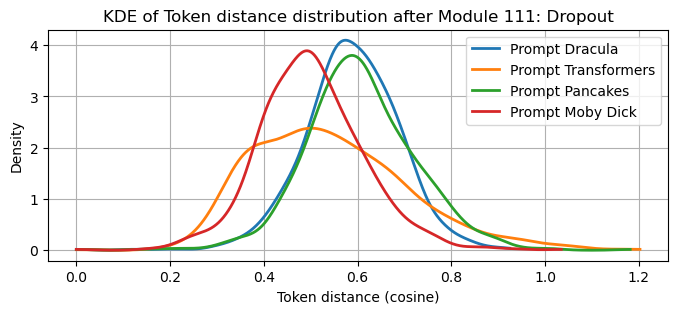

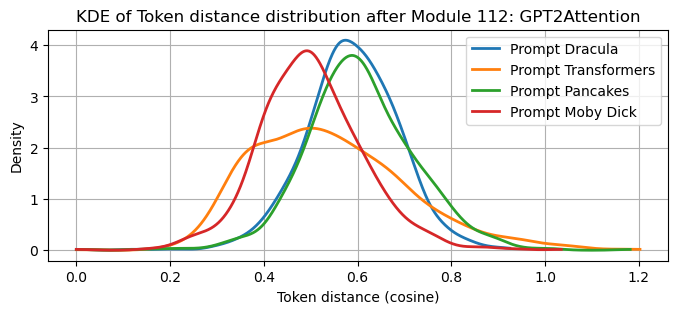

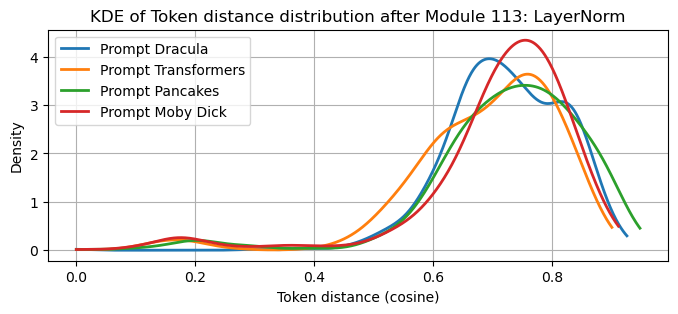

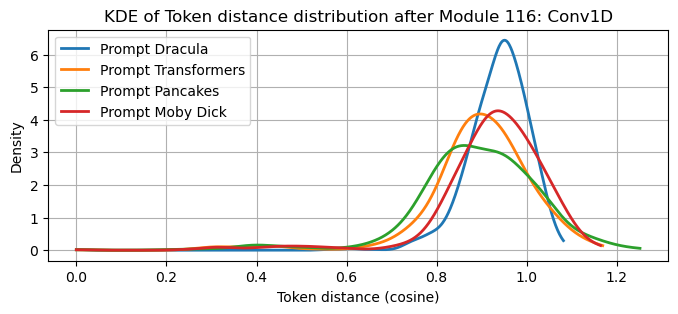

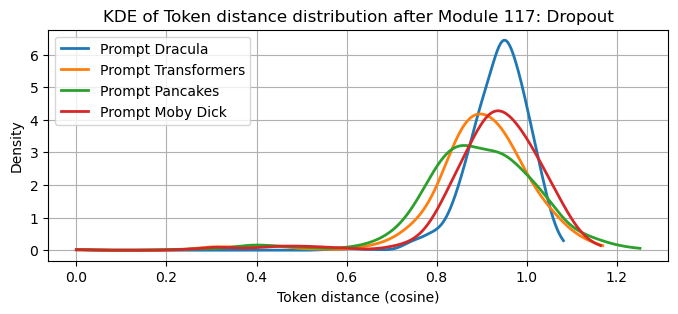

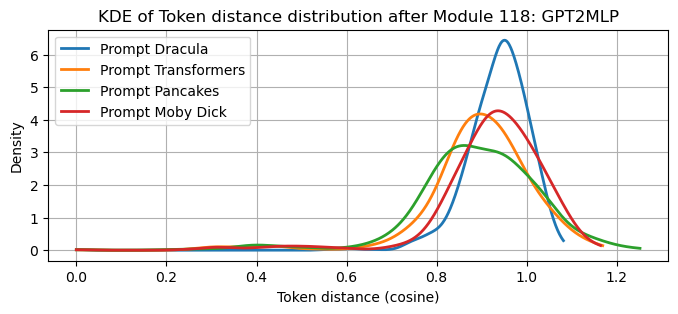

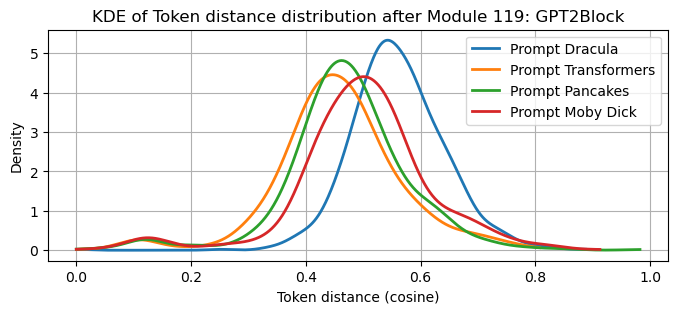

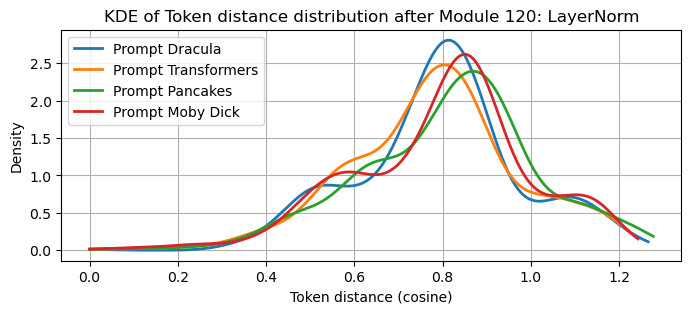

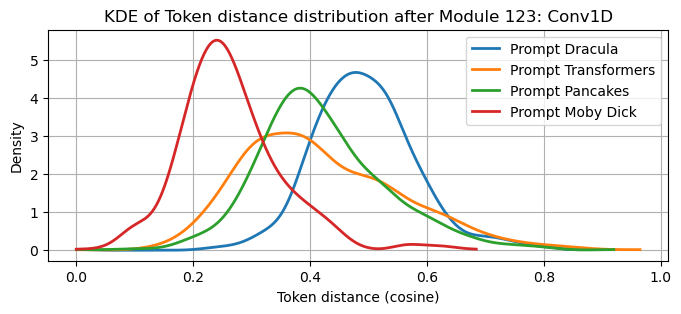

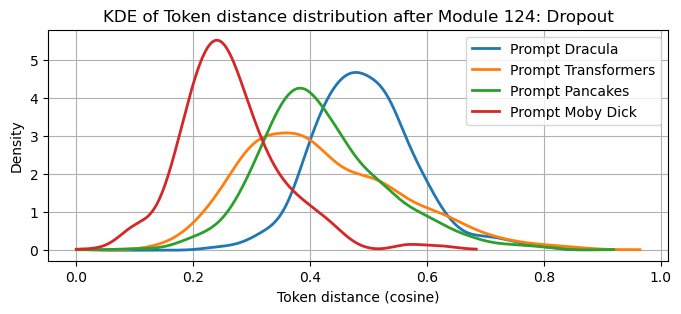

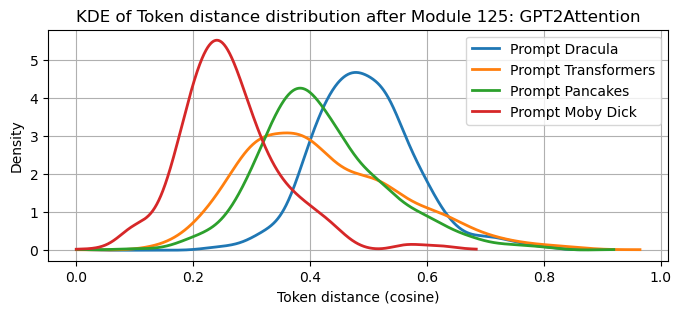

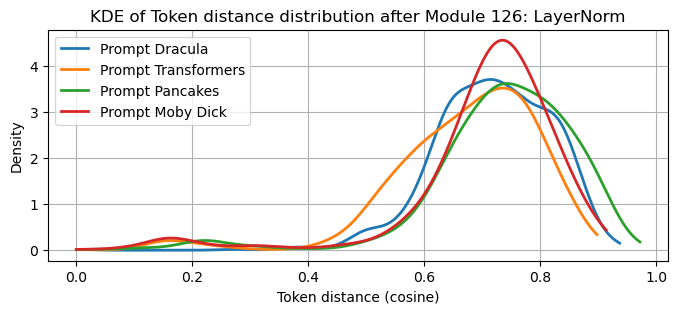

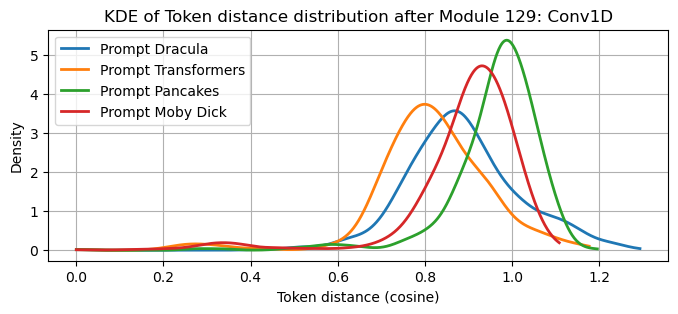

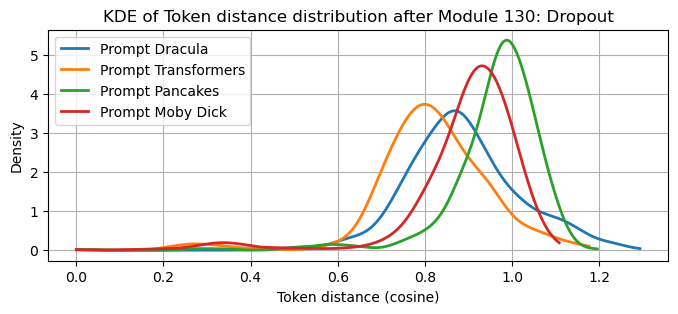

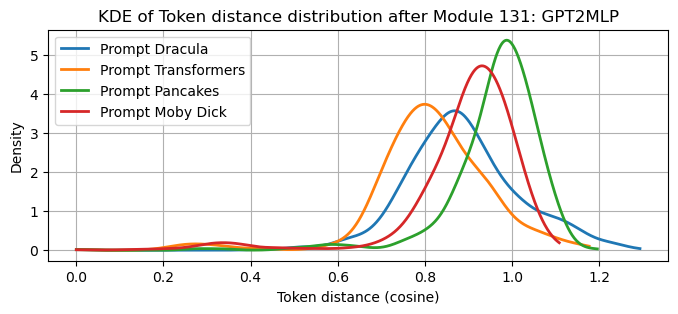

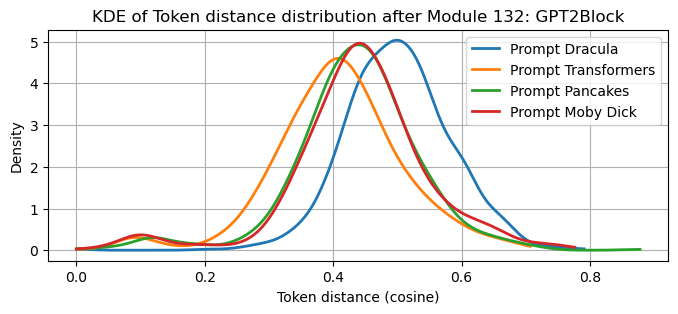

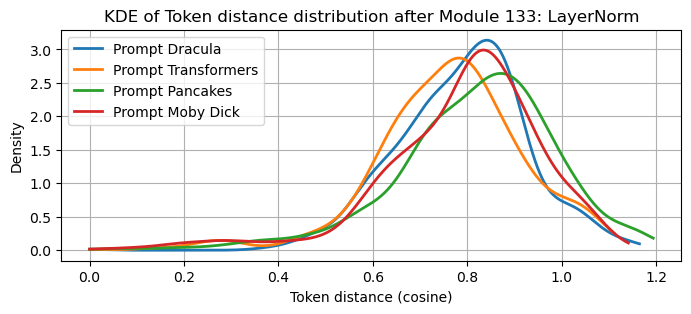

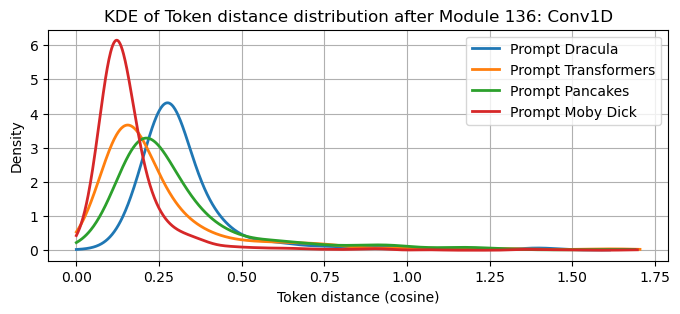

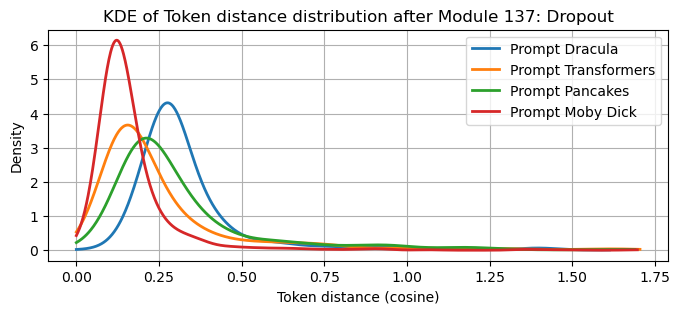

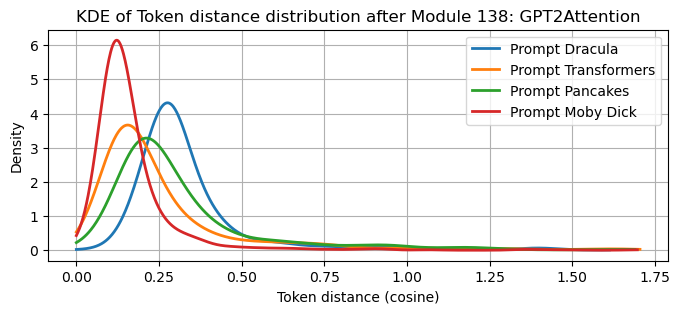

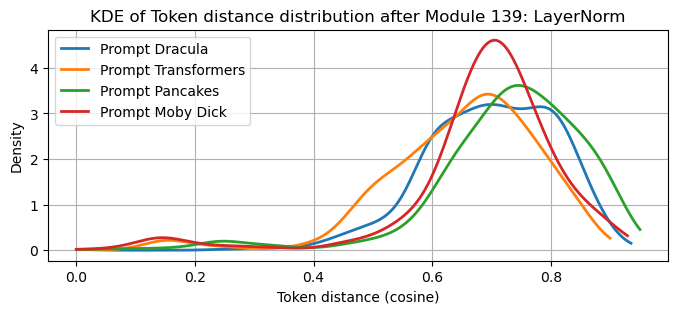

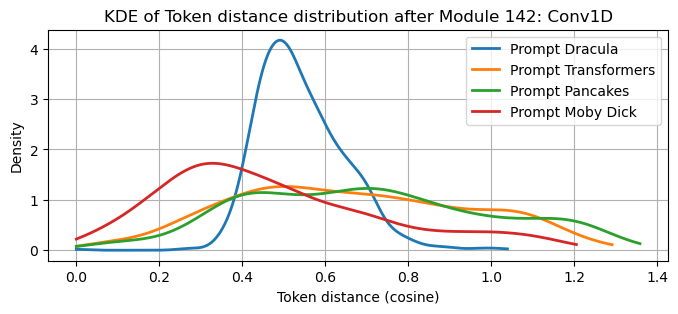

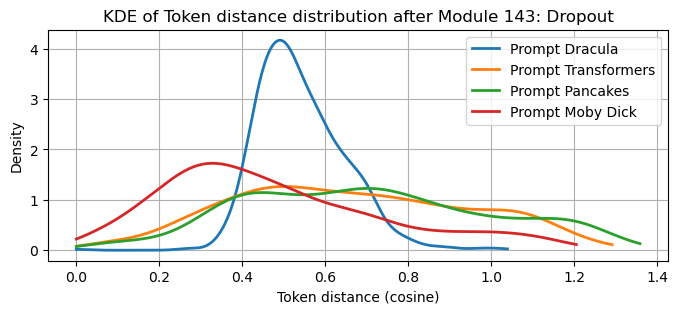

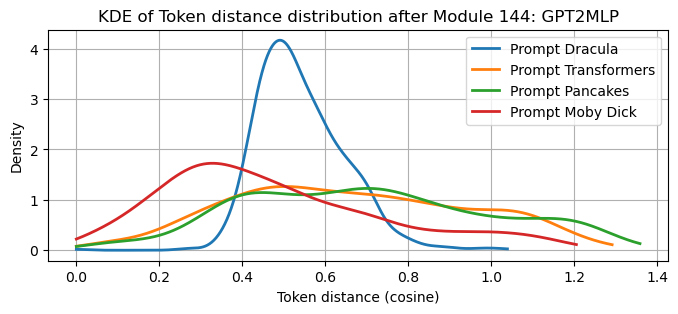

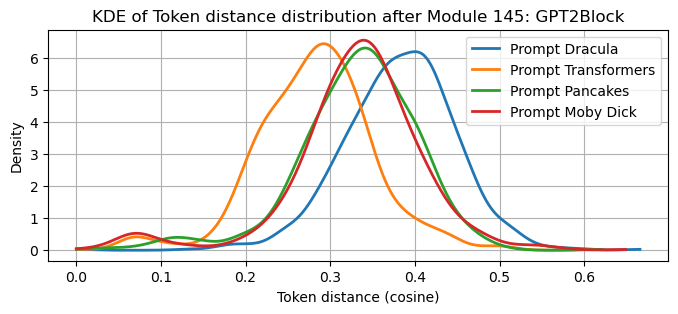

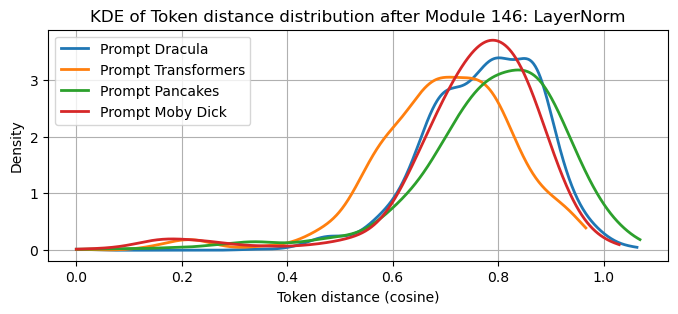

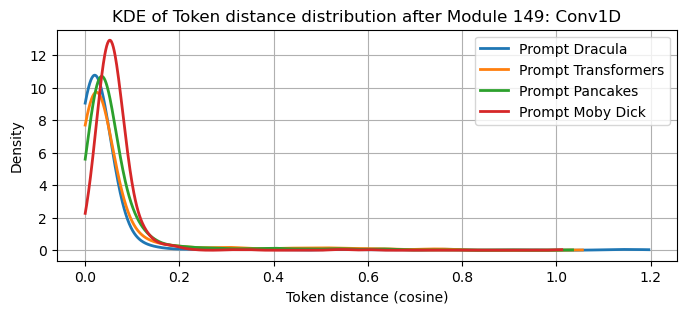

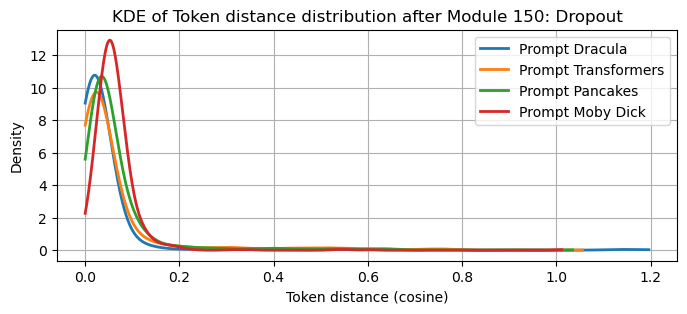

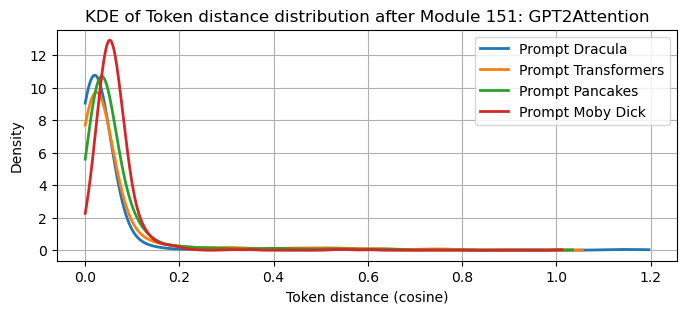

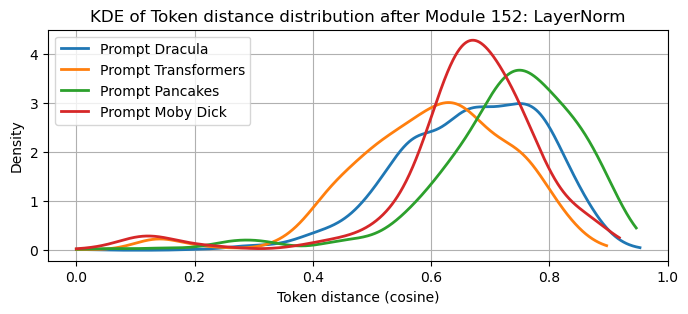

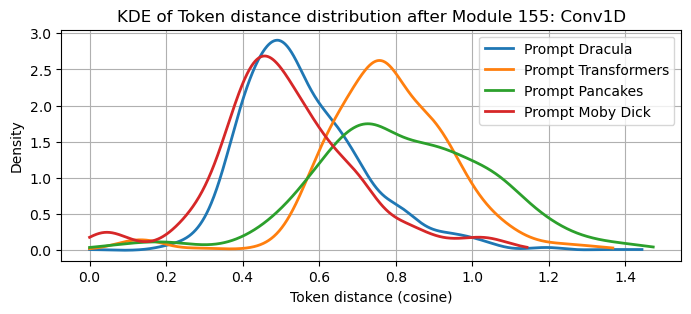

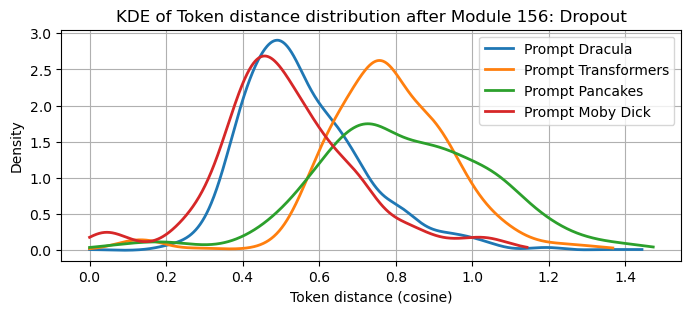

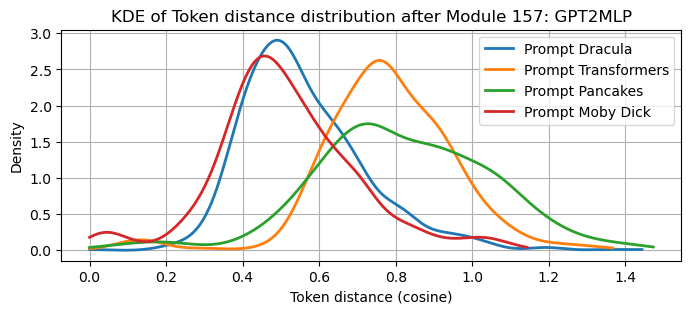

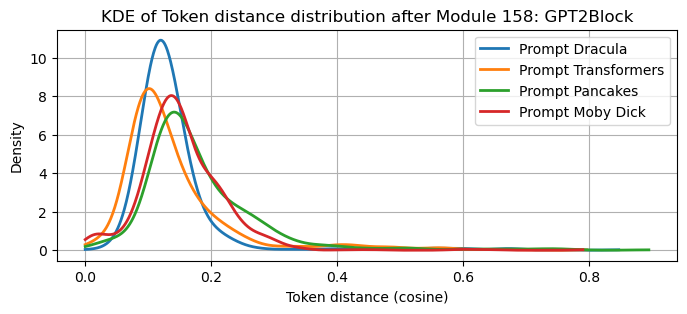

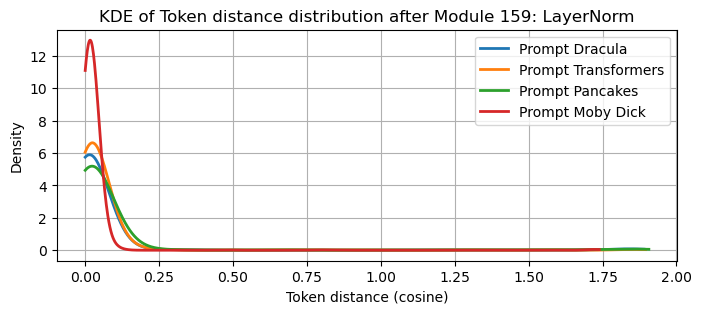

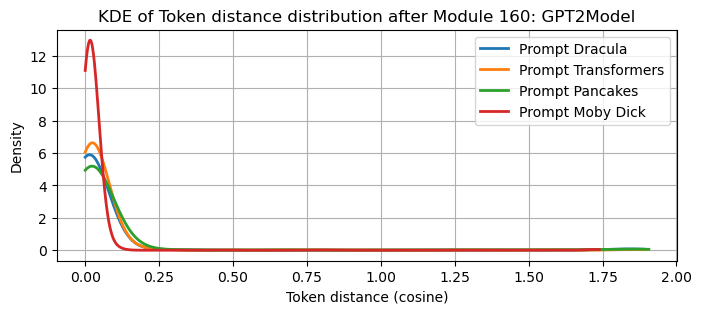

In [7]:
# Extract dist_from_token from the dictionary
dist_from_token = [dist[2] for dist in distances.values()]

# Use the idx and test_mods from one of the distances (assuming they are consistent)
idx, module_names = distances["Dracula"][:2]

# Plot KDEs
plot_labels = [f"Prompt {k}" for k in prompts.keys()]
DF.plot_kde(dist_from_token, idx, module_names, plot_labels, filename="dist_kde")